<a href="https://colab.research.google.com/github/aathira55/DL-for-computer-vision/blob/main/6_2_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

2.9.2


#Load the dataset which is already processed

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/Models/X_train_std.npy')
X_test_std = load('/content/drive/MyDrive/Models/X_test_std.npy')

y_train = load('/content/drive/MyDrive/Models/y_train.npy')
y_test = load('/content/drive/MyDrive/Models/y_test.npy')

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (400, 299, 299, 3)
X_test_std_shape: (100, 299, 299, 3)


In [5]:
# Load the saved best model

model_FineTune = keras.models.load_model('/content/drive/MyDrive/Models/01_Xception_TransferLearning_Best_Model.h5')

In [6]:
model_FineTune.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [7]:
model_FineTune.layers

In [8]:
len(model_FineTune.layers)

134

## Freeze only first 60 layers
- It is a `hyperparameter`

In [9]:
# Fine-tune the model from index 60 onwards

for layer in model_FineTune.layers[:60]:
  layer.trainable = False

for layer in model_FineTune.layers[60:]:
  layer.trainable = True


#Compile and train the model


*  Save the best weights while training




In [10]:
model_FineTune.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

callbacks_FineTune = [            
             keras.callbacks.ModelCheckpoint("bestFT.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history_FineTune = model_FineTune.fit(x = X_train_std, y = y_train, epochs=50,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks_FineTune)

Epoch 1/50
23/23 [==============================] - 20s 330ms/step - loss: 0.0394 - accuracy: 0.9917 - val_loss: 0.5394 - val_accuracy: 0.8750
Epoch 2/50
23/23 [==============================] - 6s 253ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 1.9642 - val_accuracy: 0.8000
Epoch 3/50
23/23 [==============================] - 6s 254ms/step - loss: 0.0307 - accuracy: 0.9889 - val_loss: 1.5794 - val_accuracy: 0.8000
Epoch 4/50
23/23 [==============================] - 6s 256ms/step - loss: 0.0559 - accuracy: 0.9861 - val_loss: 3.0786 - val_accuracy: 0.8000
Epoch 5/50
23/23 [==============================] - 6s 257ms/step - loss: 0.1716 - accuracy: 0.9667 - val_loss: 1.6765 - val_accuracy: 0.8500
Epoch 6/50
23/23 [==============================] - 6s 259ms/step - loss: 0.0479 - accuracy: 0.9917 - val_loss: 3.3427 - val_accuracy: 0.6500
Epoch 7/50
23/23 [==============================] - 6s 262ms/step - loss: 0.0476 - accuracy: 0.9889 - val_loss: 1.4338 - val_accuracy: 0.8000
Epoch

# Plot accuracy

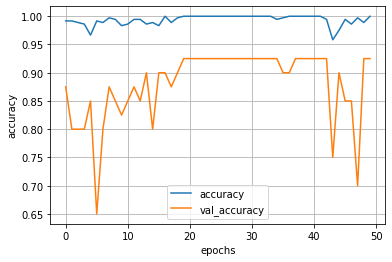

In [11]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_FineTune.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

## Evaluate the fine-tuned model
- Trained for 50-epochs

In [12]:
testLoss_FineTune, testAccuracy_FineTune = model_FineTune.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 2s 279ms/step - loss: 0.7303 - accuracy: 0.8300
Test-loss: 0.730337, Test-accuracy: 0.830000


## Update the model with best weights and evaluate
- Saved based on the callback

In [13]:
model_FineTune.load_weights("bestFT.h5")

testLoss_FineTune, testAccuracy_FineTune = model_FineTune.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 1s 166ms/step - loss: 0.5743 - accuracy: 0.8700
Test-loss: 0.574328, Test-accuracy: 0.870000


#Get the prediction of a single sample

In [14]:
cProba = model_FineTune.predict(X_test_std[:1])

print(cProba)

1/1 [==============================] - 1s 896ms/step
[[5.0051435e-15 2.5345100e-15 1.0000000e+00 4.2416872e-16 1.1112653e-15]]


In [15]:
cLabel = np.argmax(cProba, axis=-1) 

print(cLabel)

[2]


In [16]:
print(y_test[:1])

[2]


#Save the final Fine-Tuned model

In [17]:
# Saves the best model obtained
model_FineTune.save('/content/drive/MyDrive/Models/02_Xception_FineTuned_Best_Model.h5')